# Spacing Analysis

# Imports

In [2]:
import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
from matplotlib import pyplot as plt
### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/spacing_analysis//')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin




env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin


## Make Track hubs

### ATAC

In [ ]:
%%capture
!makeMultiWigHub.pl spacing_ATAC mm10 -force -d ./tag_directories_thiomac/C57Bl6_Thiomac_ATAC_*/

### RNA

In [ ]:
%%capture
!makeMultiWigHub.pl spacing_RNA mm10 -force -strand -d ./tag_directories_thiomac/C57Bl6_Thiomac_GRO*/  ./tag_directories_thiomac/C57Bl6_Thiomac_RNA*/

### 5GRO

In [ ]:
%%capture
!makeMultiWigHub.pl spacing_5GRO mm10 -force -strand -fragLength 1 -d ./tag_directories_thiomac/C57Bl6_Thiomac_5GRO*/

## QC

In [14]:
%%capture
!summarize_logs.py atac ./qc_atac ./tag_directories_thiomac/*ATAC*/
!summarize_logs.py gro ./qc_gro ./tag_directories_thiomac/*_GRO_*/
!summarize_logs.py gro ./qc_5gro ./tag_directories_thiomac/*_5GRO_*/
!summarize_logs.py rna ./qc_rna ./tag_directories_thiomac/*_RNA_*/

### Read in QC Stats

In [3]:
summary_gro_frame = pd.read_csv('./qc_gro/mapping_stats.tsv', sep='\t')
summary_gro_frame['genome'] = 'mm10'
sample_names = summary_gro_frame['sample'].values
summary_gro_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_gro_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_gro_frame['treatment'] = [x.split('_')[3] for x in sample_names]

summary_5gro_frame = pd.read_csv('./qc_5gro/mapping_stats.tsv', sep='\t')
summary_5gro_frame['genome'] = 'mm10'
sample_names = summary_5gro_frame['sample'].values
summary_5gro_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_5gro_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_5gro_frame['treatment'] = [x.split('_')[3] for x in sample_names]

summary_atac_frame = pd.read_csv('./qc_atac/mapping_stats.tsv', sep='\t')
summary_atac_frame['genome'] = 'mm10'
sample_names = summary_atac_frame['sample'].values
summary_atac_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_atac_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_atac_frame['treatment'] = [x.split('_')[3] for x in sample_names]




## Call TSS

The option "-style tss" basically expands to "-C 0 -strand separate -fragLength 1 -inputFragLength 1 -tbp 0 -inputtbp 0 -size 150"

--Homer Documentation

http://homer.ucsd.edu/homer/ngs/tss/index.html

In [4]:
# different parameters to try
peak_sizes = [25,50, 100,150]
background_ratios = [0,1,2,4]


In [ ]:
treatments = sorted(set(summary_5gro_frame['treatment'].values)) # from the QC data frame - get the unique treatment conditions

tss_final_path = './tss/' # directory containing the TSS files for each treatment and parameter combination
tag_dir_path_5gro = './tag_directories_thiomac/' # where the tag directories are
tag_dir_path_gro = './tag_directories_thiomac/' # where the tag directories are
tss_path = './tss_scratch/' # where Homer will write the individual files - will be messy

# if directories where outputs will be written don't exist create them
if not os.path.isdir(tss_path):
    os.mkdir(tss_path)
if not os.path.isdir(tss_final_path):
    os.mkdir(tss_final_path)
# loop over peak sizes
for ps in peak_sizes:
    #loop over bacground ratios
    for br in background_ratios:
        print
        # clear the scratch directory
        for f in os.listdir(tss_path):
            os.remove(tss_path + '/' + f)
            
        # loop over the treatments [veh, kla]
        for treatment in treatments:
            print(treatment, 'peak size:', ps, 'enrichment over background:', br)
            # get GRO-seq samples (tag directory names) that match the current treatment
            samples_gro = summary_gro_frame[summary_gro_frame['treatment'] == treatment]['sample'].values
            # get 5' GRO-seq samples (tag directory names) that match the current treatment
            samples_5gro = summary_5gro_frame[summary_5gro_frame['treatment'] == treatment]['sample'].values

            # call TSS using both GRO-seq samples as input for each 5GRO experiment
            counter_5gro = 1 # counter for naming TSS file for each 5Gro replicate
            replicate_list = [] # list for holding TSS filename for each 5GRO replicate
            
            # loop over 5Gro replicates for current condition
            for samp_5gro in samples_5gro:
                command = 'findPeaks ' + tag_dir_path_5gro + samp_5gro + ' -style tss -size ' + str(ps) + ' -F ' + str(br) + ' ' 
                counter_gro = 1 # counter for naming the TSS file name according to which background file was used
                tss_path_list = [] # list for holding TSS file name for current 5GRO sample with different background files
                
                # loop over background files
                for samp_gro in samples_gro:
                    current_command = command + ' -i '+ tag_dir_path_gro + samp_gro + ' -o '
                    current_tss_path = tss_path + treatment + '_rep' + str(counter_5gro) + '_input' + str(counter_gro) + '_tss.tsv'
                    current_command = current_command + ' ' + current_tss_path
                    counter_gro += 1
                    tss_path_list.append(current_tss_path)
                    print(current_command)
                    os.system(current_command) # call Homer to call TSS
                    
                # merge tss called using different inputs together
                merge_command = 'mergePeaks ' + ' '.join(tss_path_list) + ' -prefix ' + tss_path + treatment
                print(merge_command)
                os.system(merge_command)
                
                # rename intersection file
                intersection_path = treatment + '_.' + '_.'.join([x.replace('./','_').replace('/','_') for x in tss_path_list])
                renamed_intersection_path = tss_path + treatment + '_rep'+str(counter_5gro) + '_tss.tsv'
                os.system('cp ' + tss_path+  intersection_path + ' '+ renamed_intersection_path)
                replicate_list.append(renamed_intersection_path)
                counter_5gro += 1
                
            # merge replicates for each condition
            merge_command = 'mergePeaks ' + ' '.join(replicate_list) + ' -prefix ' + tss_path + treatment
            print(merge_command)
            os.system(merge_command)
            
            # rename merged replicate
            merged_replicate_path = treatment + '_.' + '_.'.join([x.replace('./','_').replace('/','_') for x in replicate_list])
            # final file name is treatment_backgroundRatio_peakSize_tss.tsv
            renamed_merged_replicate_path = tss_final_path + treatment + '_' + str(br) + '_' + str(ps) + '_tss.tsv'
            # copy file
            os.system('cp ' + tss_path+  merged_replicate_path + ' '+ renamed_merged_replicate_path)



KLA-1h peak size: 25 enrichment over background: 0
findPeaks ./tag_directories_thiomac/C57Bl6_Thiomac_5GRO_KLA-1h_SD_16-08-03-SD279 -style tss -size 25 -F 0  -i ./tag_directories_thiomac/C57Bl6_Thiomac_GRO_KLA-1h_SD_16-08-16-SD273 -o  ./tss_scratch/KLA-1h_rep1_input1_tss.tsv
findPeaks ./tag_directories_thiomac/C57Bl6_Thiomac_5GRO_KLA-1h_SD_16-08-03-SD279 -style tss -size 25 -F 0  -i ./tag_directories_thiomac/C57Bl6_Thiomac_GRO_KLA-1h_SD_16-08-16-SD274 -o  ./tss_scratch/KLA-1h_rep1_input2_tss.tsv
mergePeaks ./tss_scratch/KLA-1h_rep1_input1_tss.tsv ./tss_scratch/KLA-1h_rep1_input2_tss.tsv -prefix ./tss_scratch/KLA-1h
findPeaks ./tag_directories_thiomac/C57Bl6_Thiomac_5GRO_KLA-1h_SD_16-08-03-SD280 -style tss -size 25 -F 0  -i ./tag_directories_thiomac/C57Bl6_Thiomac_GRO_KLA-1h_SD_16-08-16-SD273 -o  ./tss_scratch/KLA-1h_rep2_input1_tss.tsv


### Read in TSS

In [142]:
tss_veh_frame = pd.read_csv('./tss/Veh_0_25_tss.tsv', sep='\t')
 # renames first column
columns = tss_veh_frame.columns.values
columns[0] = 'ID'
tss_veh_frame.columns = columns


num veh tss 15857 num kla tss 10131


### Visualize change in start positions

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


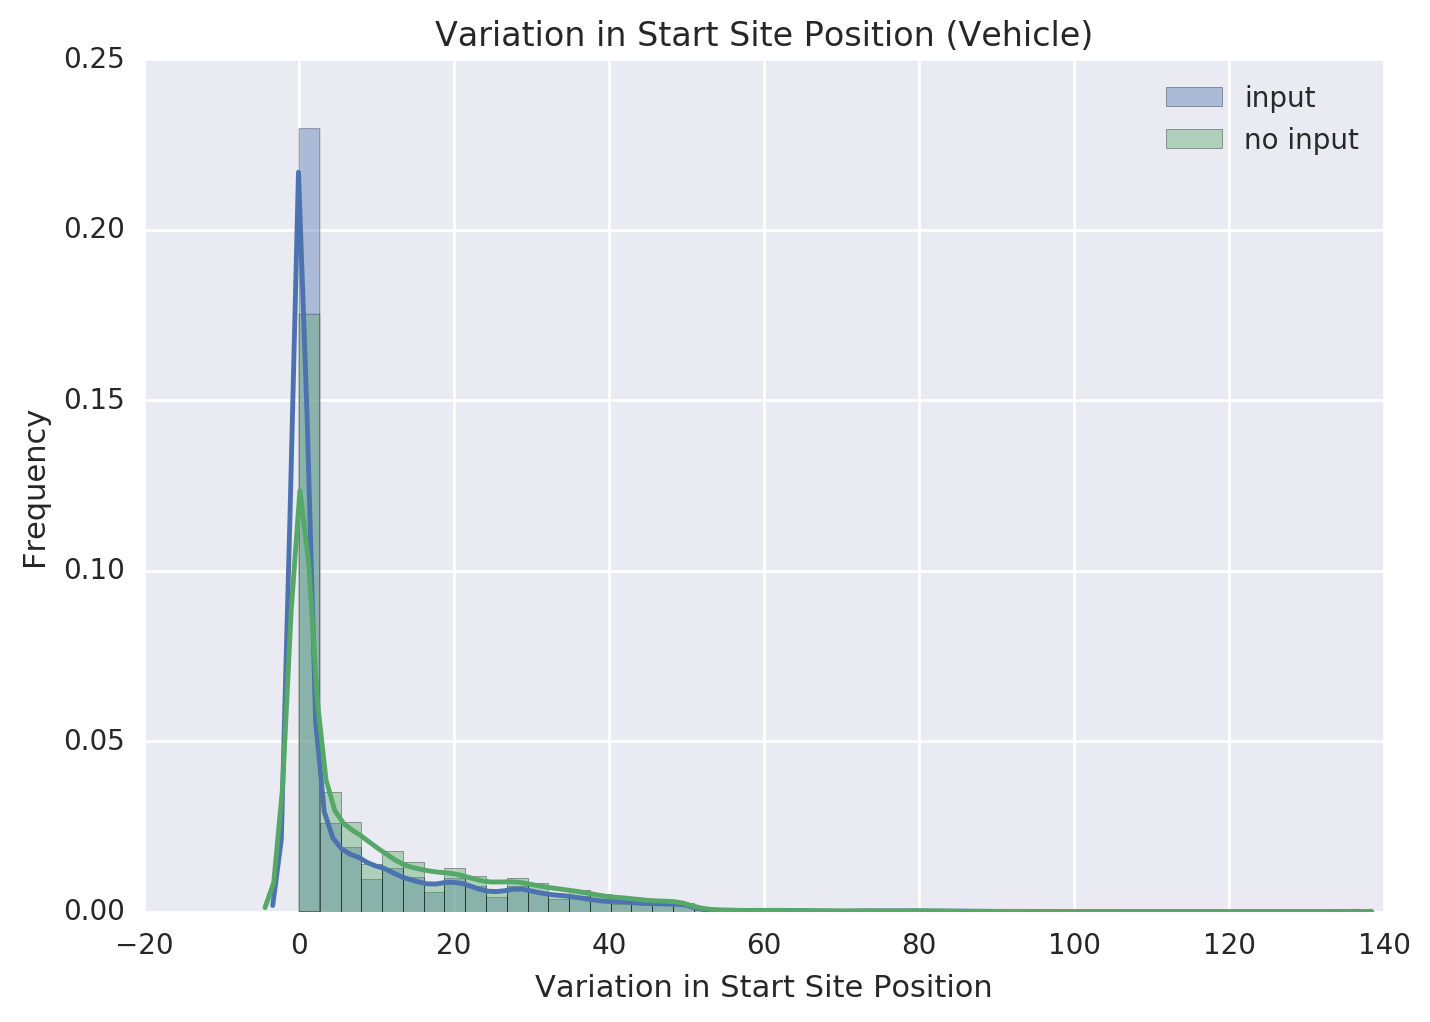

In [140]:
sns.distplot(tss_veh_frame['end'] - tss_veh_frame['start'] - _peak_size, label='input')
plt.xlabel('Variation in Start Site Position')
plt.ylabel('Frequency')
plt.title('Variation in Start Site Position (Vehicle)')

### Filter on Tolerances

#### Calculate peak sizes

In [133]:
tss_veh_frame['size'] = tss_veh_frame['end'] - tss_veh_frame['start']

tss_veh_noinput_frame['size'] = tss_veh_noinput_frame['end'] - tss_veh_noinput_frame['start']


In [ ]:
# filter on tolerance
filtered_tss_veh_frame = tss_veh_frame[tss_veh_frame['size'] <= peak_size + Mtolerance]

# create bed file
filtered_tss_veh_bed_frame = filtered_tss_veh_frame[['chr', 'start', 'end', 'ID', 'Total subpeaks', 'strand']]
print('num veh tss', filtered_tss_veh_frame.shape[0]
      )
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')
filtered_tss_veh_bed_frame.to_csv('./bed_files/veh_tss.bed', sep='\t', index=False, header=False)


